# My first introduction to pytorch


i am starting with 'what is torch.nn really?' (see [here](https://pytorch.org/tutorials/beginner/nn_tutorial.html)) since it is the most concise example code that i can find.

In [7]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## MNIST data setup

In [8]:
#this is just creating a data folder for the MNIST dataset
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)


let's open the appropriate gzip file in numpy array format (which is stored as a pickle)

In [9]:
import pickle, gzip
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [10]:
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(50000, 784) (50000,)
(10000, 784) (10000,)


so training data has 50000 28x28 images (stored as a flattened row) whereas validation has 10000 images. let's plot one of the images

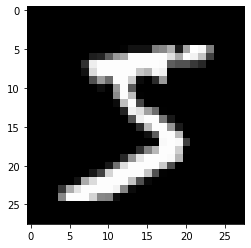

In [11]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap='gray')

convert to torch tensors...

In [12]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [13]:
n, c

(50000, 784)

ok so these data are pretty readable

## Neural Network from scratch (no torch.nn)

In [14]:
import math
weights = torch.randn(784, 10) / math.sqrt(784) #normalizing a randomly initialized weight matrix
weights.requires_grad_(True) #then making it gradable
bias = torch.zeros(10, requires_grad=True) #making a linear bias term of zeros that is linear gradable

In [15]:
def log_softmax(x): #take the exponential probability
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb): #weird @ terma makes the batch train broadcast weights...
    return log_softmax(xb @ weights + bias)

In [16]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-2.0556, -2.1799, -2.0864, -2.9918, -2.5170, -2.7939, -1.9698, -2.3290,
         -2.6780, -1.9868], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

In [17]:
def nll(input, target): #just take the input array 
    return -input[range(target.shape[0]), target].mean()

In [18]:
loss_func = nll

In [19]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3525, grad_fn=<NegBackward>)

In [20]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [21]:
print(accuracy(preds, yb))

tensor(0.0781)


that is quite shit. let's 
- select a mini-batch of data (of size bs)
- use the model to make a prediction
- calculate the loss
- `loss.backward()` call to update the model gradient

In [22]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [23]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0802, grad_fn=<NegBackward>) tensor(1.)


## now we can refactor with `torch.nn.functional`

In [24]:
import torch.nn.functional as F
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias



## refactor with `nn.Module`

In [25]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [26]:
model = Mnist_Logistic()


In [27]:
callable(model)

True

In [21]:
vars(model)

{'training': True,
 '_parameters': OrderedDict([('weights',
               Parameter containing:
               tensor([[-0.0253,  0.0062,  0.0290,  ...,  0.0151,  0.0147, -0.0144],
                       [ 0.0410, -0.0468, -0.0202,  ..., -0.0052, -0.0381,  0.0441],
                       [-0.0294, -0.0125, -0.0106,  ..., -0.0194,  0.0285,  0.0204],
                       ...,
                       [-0.0123, -0.0134,  0.0504,  ...,  0.0081, -0.0827,  0.0087],
                       [-0.0111,  0.0147, -0.0150,  ..., -0.0386,  0.0660,  0.0346],
                       [-0.0571,  0.0319,  0.0332,  ..., -0.0039,  0.0513, -0.0330]],
                      requires_grad=True)),
              ('bias',
               Parameter containing:
               tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))]),
 '_buffers': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),


In [22]:
linmodel = nn.Linear(2, 3)

In [23]:
linmodel._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[ 0.4335,  0.2855],
                      [ 0.5475, -0.5615],
                      [ 0.1932,  0.6852]], requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([0.2949, 0.0808, 0.3318], requires_grad=True))])

In [24]:
with torch.no_grad():
    linmodel._parameters['weight'].data = torch.ones(3,2)

In [25]:
linmodel._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[1., 1.],
                      [1., 1.],
                      [1., 1.]], requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([0.2949, 0.0808, 0.3318], requires_grad=True))])

In [26]:
with torch.no_grad():
    for parameter in linmodel.parameters():
        parameter += torch.eye(3)

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1

In [ ]:
linmodel._parameters['weight']

In [27]:
params = [param  for param in linmodel.parameters()]
with torch.no_grad():
    
    params[0] += torch.eye(3)

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1

In [28]:
params[0] += torch.eye(3)

RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.

In [29]:
a = torch.tensor([3.,4.,5.], requires_grad=True)
b = (2.*a**2).sum()

In [30]:
b.backward()

In [31]:
type(a.grad)

torch.Tensor

In [32]:
seq = nn.Sequential(nn.Linear(2,3), nn.Tanh(), nn.Linear(2,3))

In [33]:
print([param for param in seq.parameters()])

[Parameter containing:
tensor([[ 0.5388, -0.2660],
        [ 0.1873, -0.0792],
        [ 0.6674, -0.6481]], requires_grad=True), Parameter containing:
tensor([ 0.3123, -0.3795,  0.6036], requires_grad=True), Parameter containing:
tensor([[-0.2998, -0.5869],
        [ 0.3183, -0.4068],
        [ 0.4088, -0.5266]], requires_grad=True), Parameter containing:
tensor([-0.6193, -0.6013,  0.0169], requires_grad=True)]


## skipping the following refactoring steps:
- refactoring using `nn.Linear` 
- refactor using `nn.optim`


## refactor using dataset

In [34]:
from torch.utils.data import TensorDataset

we can iterate over and slice `x_train` and `y_train` more easily with a `TensorDataset`


In [35]:
train_ds = TensorDataset(x_train, y_train)

In [36]:
xb, yb = train_ds[bs : bs + bs]

In [37]:
print(xb.shape, yb.shape)

torch.Size([64, 784]) torch.Size([64])


## refactor using DataLoader

In [38]:
from torch.utils.data import DataLoader

In [39]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size = bs)

In [40]:
bs

64

looping over training data is a lot easier now...

In [41]:
for xb, yb in train_dl:
    pass

## add validation

In [42]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size = bs, shuffle=True) #shuffling prevents correlation between batches and overfitting

In [43]:
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size = bs * 2)

i can track validation as a function of every training epoch...

## skipping...
- create `fit` and `get_data` functions
- switch to `CNN`
- `nn.Sequential`
- wrapping `DataLoader`
- using your `GPU`

# 1. Dummy N-dimensional controlling modules

here, i'll attempt to make parameterizable `nn.Module` subclasses in order to parameterize an n-dimensional twisted sequential monte carlo sampler. since i am twisting an ULA sampler, i need to parameterize $A_0$, $b_0$, $c_0$, as well as their $t$ sequence counterparts. the only difference is that $A_t$ and $b_t$ are functions of $x_{t-1}$

since the twisted potentials at iterations $i>0$ are the _summation_ of previous twisting potentials, we need to make a function that aggregates twists...this should be easily implementable as a function that takes a class with a list of appropriate parameters, at which point, it adds the parameters and returns the output control, whether it is a matrix like $A$, a vector like $b$, or a scalar like $c$

## making a dummy parameterization of a 1-dimensional function

In [146]:
from torch import nn

define a model...

In [147]:
class quad_model(nn.Module):
    """
    basic function to variationally perform regression on a 1d quadratic of the form y = a(x-b)**2 + c
    """
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.randn(1, dtype=torch.double))
        self.b = nn.Parameter(torch.randn(1, dtype=torch.double))
        self.c = nn.Parameter(torch.randn(1, dtype=torch.double))
        
        #do a test...
        test_a = torch.randn(10, 1)
        a = torch.randn(1)
        test_a**2 @ a
        
    def forward(self, x):
        summand = x-self.b
        prod = summand**2
#         print(prod)
#         print(self.a)
        mult = prod @ self.a
        adder = mult + self.c
        return adder
        

define a loss function (we'll do MSE since our data will have Gaussian noise)

In [148]:
import torch.nn.functional as F
loss_func = F.mse_loss


i'll make some training, validation, and test data

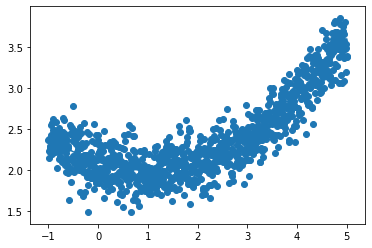

In [149]:
num_datapoints = 1000
xs = np.linspace(-1, 5, num_datapoints)
a = 0.1
b = 1.
c = -2.
y_perfect = a * (xs -b)**2 -c
ys_noisy = y_perfect + 0.2*np.random.randn(num_datapoints)
plt.plot(xs, y_perfect)
plt.scatter(xs, ys_noisy)

we should be able to refactor with `Datasets`

In [150]:
from torch.utils.data import TensorDataset, DataLoader

In [151]:
#xs = torch.reshape(torch.tensor(xs), (num_datapoints, 1))
#ys = torch.reshape(torch.tensor(ys_noisy), (num_datapoints, 1))

#make validation
validation_percent = 0.2
validation_indices = np.random.choice(num_datapoints, size=int(validation_percent*num_datapoints), replace=False)
test_indices = np.array([idx for idx in range(num_datapoints) if idx not in validation_indices])
x_test = torch.from_numpy(xs[test_indices])
y_test = torch.from_numpy(ys_noisy[test_indices])

x_valid = torch.from_numpy(xs[validation_indices])
y_valid = torch.from_numpy(ys_noisy[validation_indices])

let's load the data so we can minibatch!

In [152]:
train_ds = TensorDataset(x_test, y_test)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size = bs*2)

In [153]:
valid_ds.tensors[0].size()

torch.Size([200])

now that the data are appropriately loadable, let's import optim for training

In [154]:
from torch import optim

In [155]:
x_valid.size()

torch.Size([200])

In [156]:
model = quad_model()
lr=1e-4
opt= optim.SGD(model.parameters(), lr=1e-3)

In [157]:
callable(opt)

False

In [158]:
num_epochs = 1000
sum_valid_losses = []
import tqdm
for epoch in tqdm.trange(num_epochs):
    for _x, _y in train_dl:
        __x = _x.reshape(len(_x), 1)
        __y = _y.reshape(len(_x), 1)
        pred = model(__x)
        loss = loss_func(pred, _y)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    with torch.no_grad():
        valid_loss = sum(loss_func(model(torch.reshape(qr, (len(qr), 1))), yr) for qr, yr in valid_dl)
        sum_valid_losses.append(valid_loss)

100%|██████████| 1000/1000 [00:09<00:00, 105.85it/s]


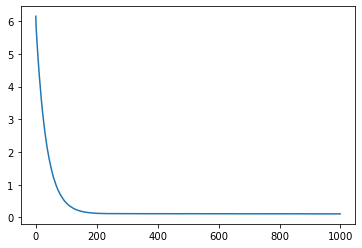

In [159]:
plt.plot(sum_valid_losses)

In [160]:
fitted_a = model._parameters['a'].data.numpy()
fitted_b = model._parameters['b'].data.numpy()
fitted_c = model._parameters['c'].data.numpy()

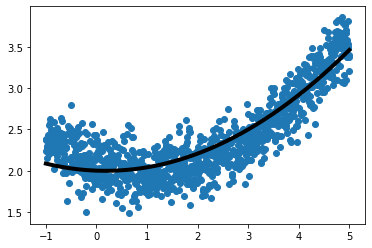

In [161]:
plt.scatter(xs, ys_noisy)
torched_xs = torch.from_numpy(xs).reshape(len(xs), 1)
torched_model = model(torched_xs)
plt.plot(xs, torched_model.detach().numpy(), linewidth=4, color = 'k')

cool! so it looks like i know how to make a simple regressor to a curve...maybe in the future i can sample the posterior parameter space or something!!

## presumably, I will be using `Sequential` to build models, but i need to be able to set parameter values appropriately because stupid reasons


In [163]:
model = nn.Sequential(nn.Linear(2,2, bias=False), nn.ReLU(), nn.Linear(2,2, bias=False))


In [64]:
_data = []
with torch.no_grad():
    for param in model.parameters():
        #param*=0.
        _data.append(param.data)
        #param += torch.ones(2,2)

In [65]:
_data

[tensor([[ 0.4393,  0.0941],
         [ 0.1493, -0.4214]]),
 tensor([[ 0.1539,  0.0988],
         [-0.1521, -0.3964]])]

In [66]:
with torch.no_grad():
    for idx, param in enumerate(model.parameters()):
        param*=0
        param += _data[idx]

In [67]:
model[0]._parameters['weight']

Parameter containing:
tensor([[0., 0.],
        [0., -0.]], requires_grad=True)

## Make twisting model for A, b, c, d in $\mathbf{R}^d$

can i make a nn.Sequential() that takes no arguments?

In [125]:
class Filler(nn.Module):
    def __init__(self):
        super().__init__()
        pass
    def forward(self, x):
        return torch.zeros(1)

In [126]:
q = nn.Sequential(
                    Filler(),
                    nn.Linear(1,5),
                    nn.Tanh(), 
                    nn.Linear(5,1)
                    )

In [141]:
r = [i for i in q.modules()]

In [145]:
q._modules.values()

odict_values([Filler(), Linear(in_features=1, out_features=5, bias=True), Tanh(), Linear(in_features=5, out_features=1, bias=True)])

In [104]:
q(input=None)

tensor([0.4390], grad_fn=<AddBackward0>)

In [128]:
a = torch.randn(100,100)

In [129]:
%time
a.numpy()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.6 µs


array([[-0.40744242,  1.1084372 ,  0.40388092, ..., -0.3438459 ,
         0.8665487 , -0.93197846],
       [-0.7907206 , -1.0912598 , -0.80066967, ...,  0.4610206 ,
        -0.79145277, -0.07211007],
       [ 0.7923572 ,  0.2600848 , -0.2662871 , ..., -0.70987254,
         0.90291226,  2.1876142 ],
       ...,
       [ 0.84203064, -1.0961756 ,  1.3285598 , ..., -0.6276878 ,
         2.5352862 ,  0.01150094],
       [ 0.5605167 ,  0.31869745,  0.3361514 , ..., -0.74210507,
         0.6429816 , -0.04131069],
       [-1.1172078 ,  0.49845922,  1.0024526 , ..., -0.12022489,
        -3.5997024 ,  1.0242313 ]], dtype=float32)

In [130]:
%time
torch.mm(a.t(), a)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs


tensor([[102.6684,  12.2103,  -5.0017,  ...,   9.9736,   9.4219,   6.2019],
        [ 12.2103, 112.8565,  -9.4376,  ...,   0.4774,   9.4906,  -7.0336],
        [ -5.0017,  -9.4376, 113.1056,  ..., -22.4520,   5.4545, -13.5073],
        ...,
        [  9.9736,   0.4774, -22.4520,  ..., 109.3932,  -4.5796,   6.0304],
        [  9.4219,   9.4906,   5.4545,  ...,  -4.5796, 118.7154, -19.6118],
        [  6.2019,  -7.0336, -13.5073,  ...,   6.0304, -19.6118,  90.1995]])

In [152]:
a = torch.tensor([[1., 2.]])
a.squeeze()

tensor([1., 2.])

In [151]:
a.dot(b)

RuntimeError: 1D tensors expected, got 2D, 1D tensors at /opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/TH/generic/THTensorEvenMoreMath.cpp:733

In [153]:
a.size()
b = torch.ones(1)

In [155]:
b = torch.tensor(1.)

In [157]:
b.numpy() + 2.

3.0

In [145]:
torch.mm(b, a.unsqueeze(1))

tensor([[3.],
        [3.]])

In [49]:
a_batch = torch.randn(4,3)
b_mult = torch.randn(3,1)

In [55]:
torch.matmul(a_batch, b_mult).squeeze().dot(torch.tensor([[1., 2., 3., 4.]]))

RuntimeError: 1D tensors expected, got 1D, 2D tensors at /opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/TH/generic/THTensorEvenMoreMath.cpp:733

In [56]:
model = nn.Linear(5,3)

In [57]:
batch = torch.randn(10, 5)

In [61]:
torch.matmul(model(batch),torch.tensor([1., 2., 3.])) 

tensor([ 3.6651,  2.7578,  2.2779, -1.1078, -1.1660,  1.1563,  2.1734,  5.4034,
         3.4679,  1.5124], grad_fn=<MvBackward>)

In [63]:
#phi = xT A x + xT b + c + d
x = torch.randn(10, 24)
A = torch.randn(10, 24, 24)
b = torch.randn(10, 24)
c = torch.randn(10)
d= torch.randn(10)



In [106]:
%time
torch.matmul(x.reshape(10, 24, 1).transpose(1,2), torch.matmul(A, x.reshape(10, 24, 1))).squeeze()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs


tensor([  3.5952,   1.4022, -46.6915, -21.3506,   2.1158, -16.7742,  35.2357,
         25.8505, -12.2151,  -3.0339])

In [107]:
%time
x.view(10, 24, 1).transpose(1,2) * (A * x.view(10, 24, 1))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs


tensor([[[-1.3580e+00, -7.6680e-01,  4.1964e-01,  ...,  3.1978e-02,
           1.2189e+00,  9.1158e-01],
         [ 1.0023e+00, -2.0690e-01,  3.7931e-01,  ...,  5.1967e-02,
           4.2002e-01,  5.8913e-01],
         [-1.7872e+00,  6.9074e-01, -3.9166e-01,  ..., -5.6590e-02,
          -4.8787e-01,  1.6135e-01],
         ...,
         [-2.4319e-02, -1.1110e-01, -2.2285e-02,  ..., -3.2465e-02,
          -1.9144e-01, -1.2058e-01],
         [-2.3816e+00,  1.7499e+00, -4.0534e-01,  ...,  2.1307e-01,
          -2.3335e+00,  2.1469e+00],
         [ 1.1695e-01,  4.0746e-01,  2.7917e-01,  ...,  6.1869e-02,
          -2.3895e+00, -1.4447e+00]],

        [[ 2.7865e-01, -2.0805e-01,  1.7034e-01,  ..., -7.5639e-01,
          -7.1633e-02, -2.7204e-01],
         [ 7.0950e-02,  1.5424e-01, -6.2388e-01,  ..., -4.7834e-02,
          -4.6210e-01, -1.4444e-01],
         [ 3.2431e-01, -8.4751e-01, -1.6211e-01,  ...,  1.2149e+00,
           6.9414e-01, -2.7786e-01],
         ...,
         [ 1.1025e+00, -1

In [121]:
a = torch.randn(10, 1, 3)
b = torch.randn(10, 1, 3)

In [122]:
a.size() == b.size()

True

In [119]:
torch.sum(a*b, dim=1)

tensor([[ 4.3877,  3.3466,  0.7851],
        [ 2.2437, -0.1509, -0.8282],
        [ 1.3333, -1.2580, -1.6293],
        [-0.1474,  0.7211, -0.2714],
        [ 1.7033,  4.6393, -7.0434],
        [ 0.5063, -0.4168, -3.0760],
        [ 0.4342,  0.5911, -0.1895],
        [-0.1561,  1.5064, -1.5107],
        [ 9.3302,  2.7908,  1.0988],
        [ 0.1560, -0.0513,  0.1423]])

In [120]:
torch.sum(b*a, dim=1)

tensor([[ 4.3877,  3.3466,  0.7851],
        [ 2.2437, -0.1509, -0.8282],
        [ 1.3333, -1.2580, -1.6293],
        [-0.1474,  0.7211, -0.2714],
        [ 1.7033,  4.6393, -7.0434],
        [ 0.5063, -0.4168, -3.0760],
        [ 0.4342,  0.5911, -0.1895],
        [-0.1561,  1.5064, -1.5107],
        [ 9.3302,  2.7908,  1.0988],
        [ 0.1560, -0.0513,  0.1423]])

In [91]:
torch.matmul(A, x.reshape(10, 24, 1)).size()

torch.Size([10, 24, 1])

In [65]:
torch.mm(x.t(), torch.matmul(A,x))

RuntimeError: size mismatch, m1: [240 x 24], m2: [10 x 24] at /opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/TH/generic/THTensorMath.cpp:136

In [ ]:
a = torch.tensor()

In [ ]:
np.ones()

In [ ]:
torch.